In [1]:
%load_ext autoreload
%autoreload 2

from src.models.gps import GPS
from src.models.explainer.explainer_pipeline import ExplainerPipeline
from src.data import loader
from src.models.explainer.attention_explainer import AttentionExplainer
from src.models.model import test
from src.models.utils.hooks import GPSHook

from torch_geometric.explain.explainer import ModelConfig, ThresholdConfig
from torch import tensor

import networkx as nx

import random

# AttentionExplainer benchmark
- GPS

## BAShapes
- 75 nodes
- ~300 edges
- 10 house motifs

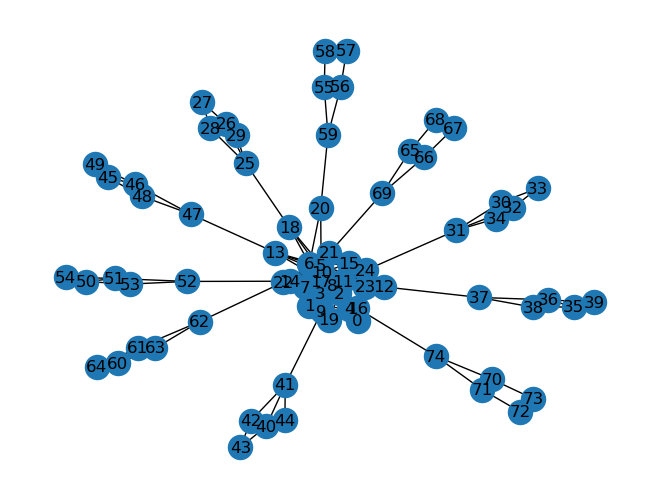

In [2]:
ba_shapes, ba_shapes_num_classes, ba_shapes_data_networkx = loader.load_clean_bashapes(num_nodes=25, num_edges=5, num_motifs=10, laplacian_eigenvector_dimensions=2)
nx.draw(ba_shapes_data_networkx, with_labels=True)

In [3]:
ba_shapes_explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
}

ba_shapes_explainer_pipelines = {
    "gps": ExplainerPipeline(
        ba_shapes,
        ba_shapes_num_classes,
        GPS,
        AttentionExplainer,
        model_params={
            'pe_channels': 2,
            'num_layers': 4,
            'hidden_channels': 4,
            'num_attention_heads': 1,
            'observe_attention': True
        },
        explainer_params=ba_shapes_explainer_params,
        epochs=400,
        Hook=GPSHook
    )
}

100%|██████████| 400/400 [00:03<00:00, 119.28it/s]


Evaluate model performance.

In [4]:
gps_train_acc, gps_test_acc = test(ba_shapes_explainer_pipelines["gps"].model, ba_shapes)

print(f"GPS train accuracy: {gps_train_acc}")
print(f"GPS test accuracy: {gps_test_acc}")

GPS train accuracy: 1.0
GPS test accuracy: 1.0


Generate and evaluate explanation for node 26, which is in a house motif. Do the same for node 0, which is in the Barabasi-Albert graph.

In [6]:
nodes = [26, 0]
for model in ba_shapes_explainer_pipelines:
    for node in nodes:
        ba_shapes_explainer_pipelines[model].explain(node, laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe, attention_computation_method="shortest_path", top_k=10)

Visualize GPS explanations.

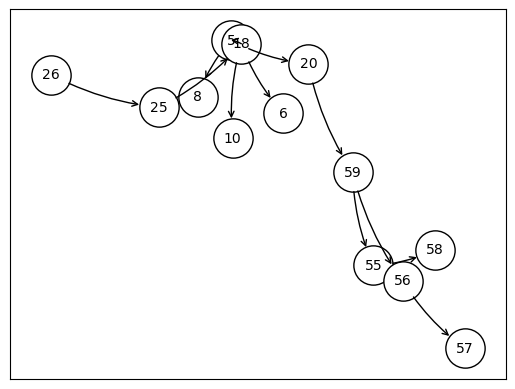

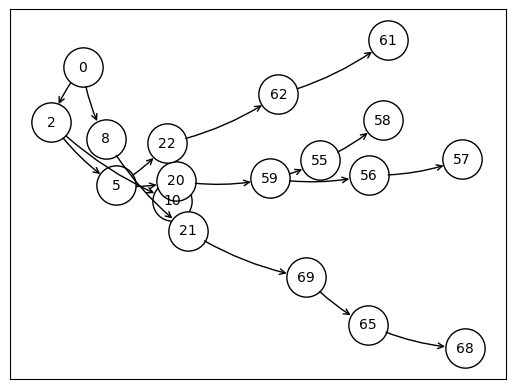

In [7]:
ba_shapes_explainer_pipelines["gps"].explanations[26].visualize_graph()
ba_shapes_explainer_pipelines["gps"].explanations[0].visualize_graph()

Evaluate explanations.

In [38]:
metrics = []
for model in ba_shapes_explainer_pipelines:
    for node in nodes:
        metrics.append([model, node, ba_shapes_explainer_pipelines[model].get_explanation_metrics(node)])

for metric in metrics:
    print(f"Model: {metric[0]}")
    print(f"Node: {metric[1]}")
    print(f"Explanation (accuracy, recall, precision, f1_score): {metric[2]}")
    print("\n")

for model in ba_shapes_explainer_pipelines:
    print(f"Model: {model}")
    pos, neg, characterization = ba_shapes_explainer_pipelines[model].get_entire_explanation_fidelity(laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe, disable_tqdm=True)
    print(f"Positive explanation fidelity: {pos}")
    print(f"Negative explanation fidelity: {neg}")
    print(f"Characterization score: {characterization}")
    print("\n")


Model: gps
Node: 26
Explanation (accuracy, recall, precision, f1_score): (0.9335442781448364, 0.11764705926179886, 0.25, 0.1599999964237213)


Model: gps
Node: 0
Explanation (accuracy, recall, precision, f1_score): (0.7310126423835754, 0.4615384638309479, 0.0714285746216774, 0.12371134012937546)


Model: gps


100%|██████████| 75/75 [00:00<00:00, 132.17it/s]

Positive explanation fidelity: 0.6133333333333333
Negative explanation fidelity: 0.5733333333333334
Characterization score: 0.5032478632478632




## PascalVOC-SP
- 499 nodes
- 2826 edges

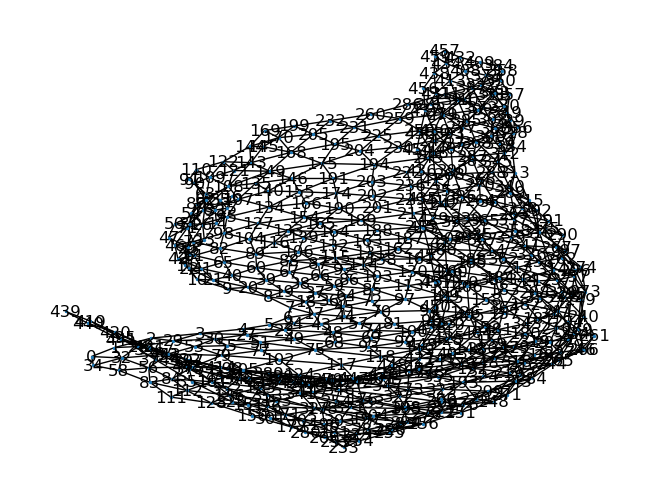

In [39]:
pascalvoc_sp, pascalvoc_sp_num_classes, pascal_voc_sp_data_networkx = loader.load_clean_pascalvoc_sp(3)
nx.draw(pascal_voc_sp_data_networkx, with_labels=True, node_size=2)

In [18]:
pascalvoc_sp_explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    )
}

pascalvoc_sp_explainer_pipelines = {
    "gps": ExplainerPipeline(
        pascalvoc_sp,
        pascalvoc_sp_num_classes,
        GPS,
        AttentionExplainer,
        model_params={
            'pe_channels': 5,
            'num_layers': 2,
            'hidden_channels': 4,
            'num_attention_heads': 4,
            'observe_attention': True
        },
        explainer_params=pascalvoc_sp_explainer_params,
        epochs=400,
        Hook=GPSHook
    ),
}

100%|██████████| 400/400 [06:25<00:00,  1.04it/s]


Evaluate model performance.

In [41]:
gps_train_acc, gps_test_acc = test(pascalvoc_sp_explainer_pipelines["gps"].model, pascalvoc_sp)

print(f"GPS train accuracy: {gps_train_acc}")
print(f"GPS test accuracy: {gps_test_acc}")

GPS train accuracy: 0.8771929824561403
GPS test accuracy: 0.92


Generate and evaluate explanation for two arbitrary nodes.

In [43]:
nodes = random.sample(range(0, pascalvoc_sp.num_nodes), 2)
for model in pascalvoc_sp_explainer_pipelines:
    for node in nodes:
        pascalvoc_sp_explainer_pipelines[model].explain(node, random_walk_pe=pascalvoc_sp.random_walk_pe, attention_computation_method="shortest_path", top_k=10)

Visualize GPS explanations.

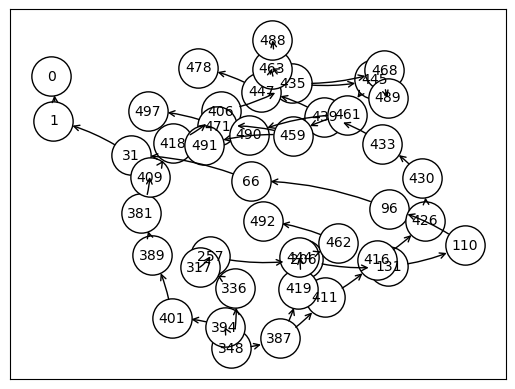

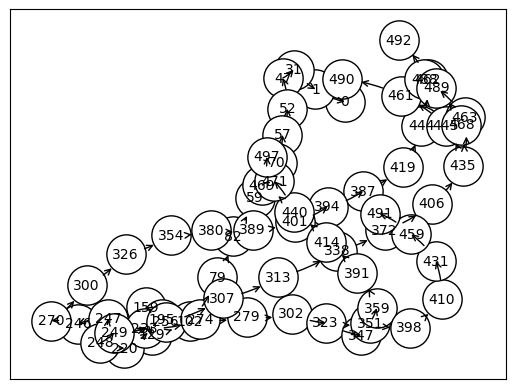

In [44]:
for node in nodes:
    pascalvoc_sp_explainer_pipelines["gps"].explanations[node].visualize_graph()

Evaluate explanations.

In [46]:
for model in pascalvoc_sp_explainer_pipelines:
    print(f"Model: {model}")
    pos, neg, characterization = pascalvoc_sp_explainer_pipelines[model].get_entire_explanation_fidelity(random_walk_pe=pascalvoc_sp.random_walk_pe, disable_tqdm=True, attention_computation_method="shortest_path", top_k=10)
    print(f"Positive explanation fidelity: {pos}")
    print(f"Negative explanation fidelity: {neg}")
    print(f"Characterization score: {characterization}")
    print("\n")


Model: gps


100%|██████████| 499/499 [08:18<00:00,  1.00it/s]

Positive explanation fidelity: 0.012024048096192385
Negative explanation fidelity: 0.02404809619238477
Characterization score: 0.023755421593694485


